In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.optim as optim
from tqdm import tqdm

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

In [25]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(0.3, 0.5, 0.5),
    transforms.ToTensor(),
])

In [26]:
dataset = datasets.ImageFolder(root="../New_Data", transform=transform)

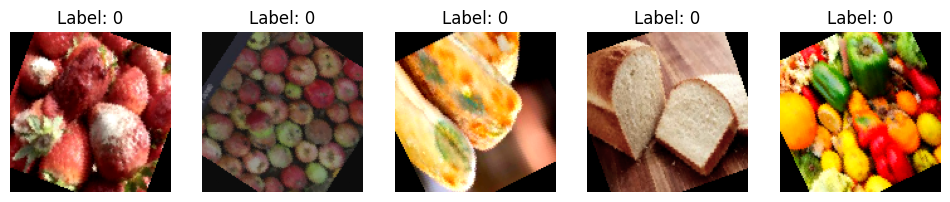

In [27]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    image, label = dataset[i]
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')
plt.show()

In [28]:
print(dataset.classes)

['biodegradable', 'cardboard', 'glass', 'metal', 'paper', 'plastic']


In [29]:
batchsize = 64

In [30]:
datasetLen = len(dataset)
train_ratio = 0.9
test_ratio = 0.1
train_size = int(train_ratio * datasetLen)
test_size = datasetLen - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [31]:
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchsize, shuffle=False, pin_memory=True)


In [32]:
example_train_data = iter(train_loader)
example = next(example_train_data)
print(example)

[tensor([[[[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118]],

         [[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118]],

         [[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 

In [33]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout_fc = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [34]:
print("HI")
for epoch in range(25):
    print("HI")
    index = 0
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, leave=True)
    for images, labels in loop:
        index+=1
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/10]")
        loop.set_postfix(loss=loss.item())
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")
    print("HO")

HI
HI


Epoch [1/10]: 100%|██████████| 103/103 [07:31<00:00,  4.38s/it, loss=1.59]


Epoch 1, Loss: 1.5078
HO
HI


Epoch [2/10]: 100%|██████████| 103/103 [07:17<00:00,  4.25s/it, loss=1.51]


Epoch 2, Loss: 1.3854
HO
HI


Epoch [3/10]: 100%|██████████| 103/103 [07:30<00:00,  4.38s/it, loss=1.75]


Epoch 3, Loss: 1.3293
HO
HI


Epoch [4/10]: 100%|██████████| 103/103 [07:29<00:00,  4.37s/it, loss=1.4] 


Epoch 4, Loss: 1.3053
HO
HI


Epoch [5/10]: 100%|██████████| 103/103 [07:35<00:00,  4.43s/it, loss=1.64]


Epoch 5, Loss: 1.2706
HO
HI


Epoch [6/10]: 100%|██████████| 103/103 [07:31<00:00,  4.38s/it, loss=1.21]


Epoch 6, Loss: 1.2110
HO
HI


Epoch [7/10]: 100%|██████████| 103/103 [07:35<00:00,  4.43s/it, loss=1.19]


Epoch 7, Loss: 1.1843
HO
HI


Epoch [8/10]: 100%|██████████| 103/103 [07:30<00:00,  4.38s/it, loss=1.54]


Epoch 8, Loss: 1.1896
HO
HI


Epoch [9/10]: 100%|██████████| 103/103 [1:09:53<00:00, 40.71s/it, loss=1.66] 


Epoch 9, Loss: 1.1844
HO
HI


Epoch [10/10]: 100%|██████████| 103/103 [37:44<00:00, 21.99s/it, loss=1.88]   


Epoch 10, Loss: 1.1590
HO
HI


Epoch [11/10]: 100%|██████████| 103/103 [21:15<00:00, 12.38s/it, loss=1.36]   


Epoch 11, Loss: 1.1146
HO
HI


Epoch [12/10]: 100%|██████████| 103/103 [21:21<00:00, 12.44s/it, loss=1.48]  


Epoch 12, Loss: 1.1012
HO
HI


Epoch [13/10]: 100%|██████████| 103/103 [05:33<00:00,  3.23s/it, loss=1.11] 


Epoch 13, Loss: 1.0936
HO
HI


Epoch [14/10]: 100%|██████████| 103/103 [05:34<00:00,  3.24s/it, loss=1.24]


Epoch 14, Loss: 1.0910
HO
HI


Epoch [15/10]: 100%|██████████| 103/103 [05:33<00:00,  3.24s/it, loss=1.25]


Epoch 15, Loss: 1.0872
HO
HI


Epoch [16/10]: 100%|██████████| 103/103 [06:04<00:00,  3.54s/it, loss=1.37]


Epoch 16, Loss: 1.0610
HO
HI


Epoch [17/10]: 100%|██████████| 103/103 [05:25<00:00,  3.16s/it, loss=1.06] 


Epoch 17, Loss: 1.0546
HO
HI


Epoch [18/10]: 100%|██████████| 103/103 [07:02<00:00,  4.10s/it, loss=1.1] 


Epoch 18, Loss: 1.0512
HO
HI


Epoch [19/10]: 100%|██████████| 103/103 [08:59<00:00,  5.23s/it, loss=1.34]


Epoch 19, Loss: 1.0463
HO
HI


Epoch [20/10]: 100%|██████████| 103/103 [10:45<00:00,  6.27s/it, loss=0.928]


Epoch 20, Loss: 1.0396
HO
HI


Epoch [21/10]: 100%|██████████| 103/103 [14:53<00:00,  8.67s/it, loss=1.05] 


Epoch 21, Loss: 1.0390
HO
HI


Epoch [22/10]: 100%|██████████| 103/103 [15:22<00:00,  8.96s/it, loss=1.48] 


Epoch 22, Loss: 1.0325
HO
HI


Epoch [23/10]: 100%|██████████| 103/103 [11:30<00:00,  6.70s/it, loss=0.957]


Epoch 23, Loss: 1.0133
HO
HI


Epoch [24/10]: 100%|██████████| 103/103 [11:50<00:00,  6.90s/it, loss=0.797]


Epoch 24, Loss: 1.0122
HO
HI


Epoch [25/10]: 100%|██████████| 103/103 [11:07<00:00,  6.48s/it, loss=1.22] 

Epoch 25, Loss: 1.0249
HO


In [35]:
model.eval()

CNNModel(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [37]:
all_preds = []
all_labels = []

In [38]:
testing_criterion = torch.nn.CrossEntropyLoss()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

In [39]:
test_loss /= len(test_loader.dataset)
test_accuracy = 100. * correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0174, Test Accuracy: 70.15%


In [40]:
torch.save(model.state_dict(), "cnn_model.pth")

In [41]:
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

In [42]:
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

               precision    recall  f1-score   support

biodegradable       0.74      0.89      0.81       163
    cardboard       0.90      0.71      0.80       115
        glass       0.69      0.73      0.71       169
        metal       0.62      0.54      0.58        90
        paper       0.65      0.66      0.65       127
      plastic       0.62      0.49      0.55        63

     accuracy                           0.71       727
    macro avg       0.70      0.67      0.68       727
 weighted avg       0.71      0.71      0.71       727



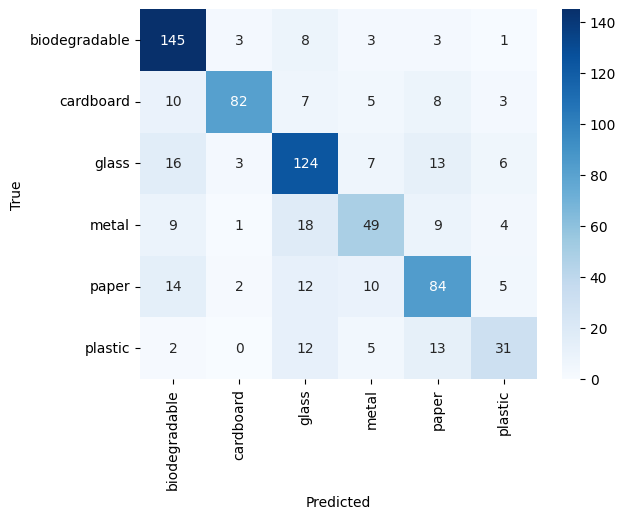

In [43]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()